
# Due Dates

* Textbook: Thursday, October 4, in class
* Coding: Thursday, October 4, at 11:59 PM

# Textbook Problems

* 2.12
* 2.22
* 2.25
* 2.26





In [1]:
# This is code to load the assignment.
# You'll need to run this code do or restart the assignment.
from loadAssignment import loadAssignment
Assignment, Questions, Submit, Data = loadAssignment(3)

# These are modules that we need
# once you run this code, you don't need to load them again
import autograd.numpy as np
import autograd as ag
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline


# Question 0

This question will deal with one of the most common uses of maximum likelihood methods: 
Fitting a statistical model via stochastic gradient ascent. 

The data imported below is collected from a [study on bank marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) and formatted according to the instructions [here](http://www2.1010data.com/documentationcenter/beta/Tutorials/MachineLearningExamples/LogisticRegression.html).



In [2]:
X_bank = Data.X_bank
Y_bank = Data.Y_bank

nData,nFeatures = X_bank.shape
print('Number of Data Points: ', nData)
print('Number of Features: ', nFeatures)

Number of Data Points:  30000
Number of Features:  27



Here the bank was attempting to get customers to subscribe for certificate of deposit (also called a term deposit). They collected a number of features such as the potential customer's job, marital status, and loan statuses. This data is represented in `X_data`. For each customer, the bank also recorded whether or not the customer subscribed for the certificate of deposit. These outcomes are stored in `Y_data`.

Each row of `X_data` is a vector of numbers storing all of the features, while each entry of `Y_data` is a corresponding $0$ or $1$ corresponding to whether the customer subscribed or not.

We will use the method of [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to find relationships between `X_data` and `Y_data`. 

This corresponds to a model of the form:
\begin{equation*}
\renewcommand{\P}{\mathbb{P}}
\P(y=1|x,\theta) = \frac{1}{1+e^{-\theta_0 -\sum_{i=1}^m \theta_i x_i}} =: h(x,\theta)
\end{equation*}
where $m$ is the number of features. Note that exponent can be represented as an inner product:
\begin{equation*}
-\theta_0 -\sum_{i=1}^m \theta_i x_i = -\theta^\top \begin{bmatrix}1 \\ x\end{bmatrix} 
\end{equation*}

Thus, the log-likelihood of a specific data point $(x,y)$ is given by:
\begin{equation*}
\ell(x,y,\theta) = y \log(h(x,\theta)) + (1-y) \log(1-h(x,\theta)
\end{equation*}

If $N = 30000$ is the total number of data points, $(x^i,y^i)$, then the log-likelihood for all the data is
is given by:
\begin{equation*}
L(\theta) = \frac{1}{N}\sum_{i=1}^N \ell(x^i,y^i,\theta)
\end{equation*}
Note here that $i$ in $x^i$ corresponds to a superscript, not an exponent. 

In principle, we could maximize this using gradient ascent. However, since the number of data points is large, computing the full gradient is expensive. Instead, we will use *stochastic gradient ascent*. The outline of the algorithm is as follows

Initialize the $\theta_0 $ to a zero vector of length $m+1$, where $m$ is the number of features.
For $k = 0,\ldots,T-1$
* Choose a random data point $(x_k,y_k)$ from `X_bank`, `Y_bank`. (This can be done by choosing a random index)
* Update: $\theta_{k+1} = \theta_k + \eta \frac{\partial}{\partial \theta} \ell(x_k,y_k,\theta_k)$
* Clip $\theta_{k+1}$ so that its entries are between $-10$ and $10$. (Use `np.clip`)

The clipping step is used to keep the values of $\theta$ in a reasonable range. Stochastic gradient algorithms can be unstable if not clipped. 

Use a step size `eta = 1e-6` and `T=1000` steps. (You can play around with making the step size bigger. However, using steps significantly larger than `1e-6` can lead to instability.)

Store your sequence of parameter values in a $(T+1)\times (m+1)$ `numpy` array called `ThetaGD`. As before, Andy encourages you to use autograd to compute the gradients. 




Spot on.
A score of 1 was entered for Question 0


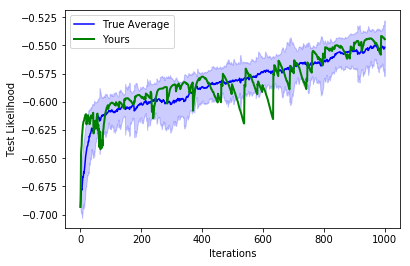

In [3]:
def prob(x,theta):
    if len(x.shape) == 1:
        z = np.hstack([1.,x])
    else:
        z = np.hstack([np.ones((x.shape[0],1)),x])
    prod = np.dot(z,theta)
    return 1./(1+np.exp(-prod))

def likeFun(x,y,theta):
    h = prob(x,theta)
    ell = y * np.log(h) + (1.-y) * np.log(1-h)
    return ell


likeGrad = ag.grad(likeFun,argnum=2)

def trainGD(dataIndices,eta=1e-6):
    theta = np.zeros(nFeatures+1)
    
    thetaList = [theta]

    for i in dataIndices:
        x = X_bank[i]
        y = Y_bank[i]
       
        grad = likeGrad(x,y,theta)
        theta = theta + eta * grad
        theta = np.clip(theta,-10,10)
        thetaList.append(theta)
        
    return np.array(thetaList)

NumSamples = 1000
dataIndices = np.random.choice(nData,size=NumSamples)
ThetaGD = trainGD(dataIndices)

Questions[0].checkAnswer(ThetaGD)


The checker plots the average log likelihood of your $\theta_k$ parameters for an unseen data set. (The "test data".) It also plots the mean and standard deviation of the true stochastic gradient ascent algorithm.

If you did the code correctly, your result should mostly lie between the standard deviation bounds plotted. However, due to randomness, there is a possibility of having the correct algorithm and being far off. In this case, run your code again to see if you get the right answer. If your run several times and keep getting it wrong, your solution is probably incorrect. 








# Question 1

The next few questions will step through a method known as `emph` natural gradient ascent. This method rescales the gradient using the inverse Fisher information matrix. 

Our model from the previous problem took the form $\P(y|x,\theta)$. In this
case, the Fisher information matrix is given by:
\begin{equation*}
\newcommand{\E}{\mathbb{E}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
F = \E\left[
\left(
\frac{\partial \log \P(\y|\x,\theta)}{\partial \theta}
\right)
\left(
\frac{\partial \log \P(\y|\x,\theta)}{\partial \theta}
\right)^\top
\right],
\end{equation*}
where the average is taken over both $\x$ and $\y$. 

Note that $F$ measures how sensitive the likelihood is to variations in $\theta$. In principle, gradient descent works much more efficiently if the gradient step is modified to:
\begin{equation*}
\theta_{k+1} = \theta_k + \eta F^{-1} \frac{\partial \ell(x_k,y_k,\theta_k)}{\partial \theta}
\end{equation*}
The reason is that in directions that are very sensitive to changes in $\theta$, the corresponding terms of $F^{-1}$ are small, and so small steps are taken, while directions that are insensitive have large $F^{-1}$ terms, and thus large steps are taken. In other words, the gradient steps are rescaled based on the sensitivity to variations in $\theta$.
(There is a deep theory behind this known as *information geometry*.)

Of course, one issue is that $F$ typically cannot be computed analytically. Plus, it depends on the parameter $\theta$, which we are attempting to estimate. 
For samples $(x_0,y_1),\ldots,(x_k,y_k)$ and corresponding $\theta_i$ values, we can approximate $F$ via the Monte Carlo method:
\begin{equation*}
F \approx F_k = \frac{1}{k+2}\left(
I +\sum_{i=0}^k s_i s_i^\top,
\right)
\end{equation*}
where
\begin{equation*}
s_i = \frac{\partial }{\partial \theta} \log\P(y_i|x_i,\theta_i)
\end{equation*}
The identity matrix in the approximation is a regularization term which ensures that $F_k$ is always invertible. 

The natural gradient algorithm can be summarized as follows:

Initialize the $\theta_0 $ to a zero vector of length $m+1$, where $m$ is the number of features. Initialize
$F_{-1}$ to be an $(m+1)\times(m+1)$ identity matrix.
For $k = 0,\ldots,T-1$
* Choose a random data point $(x_k,y_k)$ from `X_bank`, `Y_bank`. (This can be done by choosing a random index)
* Compute $F_k^{-1}$ from $F_{k-1}^{-1}$ and $s_k$. 
* Update: $\theta_{k+1} = \theta_k + \eta F_k^{-1} \frac{\partial}{\partial \theta} \ell(x_k,y_k,\theta_k)$
* Clip $\theta_{k+1}$ so that its entries are between $-10$ and $10$. (Use `np.clip`)

Note that for $k=0,1,\ldots,T-1$, we have
\begin{equation*}
F_{k}^{-1} = \left(
\frac{k+1}{k+2} F_{k-1} + \frac{1}{k+2} s_{k}s_{k}^\top
\right)^{-1}
\end{equation*}

Using the matrix inversion lemma, a formula for $F_k^{-1}$ in terms of $F_{k-1}^{-1}$ and $s_k$ can be derived which avoids inverting any matrices. (There will be a scalar inversion.) Implement this formula in a function of the form:

```
F_inv = nextFinv(F_inv_prev,s,k)
```

The running time of your functions should scale quadratically with $n$ if `F_inv` is $n\times n$. (The checker estimates your run-time scaling, but it often underestimates. So, you may be marked correct even if you implemented the naive cubically scaling algorithm. There is also a slight chance of being marked incorrect for a correct answer.)



Speed test on 100x100 matrices
Speed test on 129x129 matrices
Speed test on 166x166 matrices
Speed test on 215x215 matrices
Speed test on 278x278 matrices
Speed test on 359x359 matrices
Speed test on 464x464 matrices
Speed test on 599x599 matrices
Speed test on 774x774 matrices
Speed test on 1000x1000 matrices
Your algorithm is running in O(n^2.1) time
Correctness Tests
That is correct. Nice.
A score of 1 was entered for Question 1


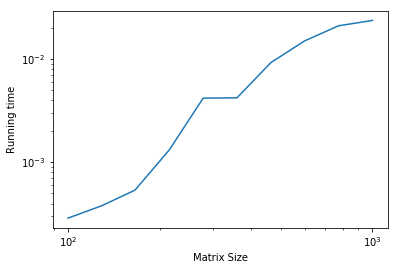

In [4]:
# Make  function called

def nextFinv(Finv,s,k):
    c = (k+2.)/(k+1.)
    prod = np.dot(Finv,s)
    den = k+1+np.dot(prod,s)

    return c * (Finv - np.outer(prod,prod)/den)



Questions[1].checkAnswer(nextFinv)


# Question 2

Implement the natural gradient algorithm. Again use $T=1000$. The natural gradient algorithm is more numerically robust than standard stochastic gradients. Thus, you should use the larger step size of $\eta = 10^{-2}$. Store your result in a $1001\times 28$ array called `ThetaNat`



Huzzah.
A score of 1 was entered for Question 2


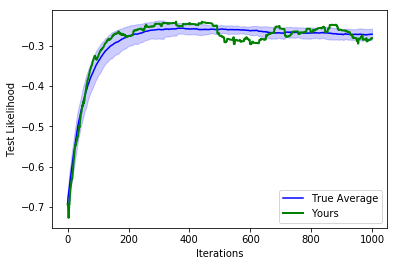

In [5]:
def trainNat(dataIndices,eta=1e-2):
    theta = np.zeros(nFeatures+1)
    F_inv = 1 * np.eye(len(theta))
    ThetaList = [theta]
    for k,i in enumerate(dataIndices):
        x = X_bank[i]
        y= Y_bank[i]
    
   
        s = likeGrad(x,y,theta)
    
        prod = np.dot(F_inv,s)
    
        F_inv = nextFinv(F_inv,s,k)
        theta = theta + eta * np.dot(F_inv,s)
    
        theta = np.clip(theta,-10,10)
        ThetaList.append(theta)
        
    return np.array(ThetaList)

NumSamples = 1000
dataIndices = np.random.choice(nData,size=NumSamples)
ThetaNat = trainNat(dataIndices)

Questions[2].checkAnswer(ThetaNat)


Note that the natural gradient reaches a higher likelihood and converges much more quickly than the standard gradient algorithm. 






# Question 3




In class we discussed Bayes rule:
\begin{equation*}
\newcommand{\q}{\mathbf{q}}
p(x|y) = \frac{p(y|x)p(x)}{p(y)}
\end{equation*}
Here $p(y|x)$ is called the likelihood and $p(x)$ is called the prior. 
The process of computing the posterior, $p(x|y)$, from $p(y|x)$ and $p(x)$ is called 
*Bayesian inference*.

We saw that for Gaussians, there are clean analytic formulas for Bayesian 
inference. In particular, if the prior and likelihood are both Gaussians,
then the posterior is again a Gaussian. More generally, if the posterior 
distribution, $p(x|y)$, and the prior distribution, $p(x)$ are the same
type of distribution, we say that $p(x)$ is a *conjugate prior*.

Let $\y\in\{0,1\}$ be the outcome of flipping a coin with unknown bias $\q$: 
\begin{equation*}
\P(y|q) = q^y(1-q)^(1-y)
\end{equation*}
In other words, $\y$ is a Bernoulli random variable parameter $\q$. 

The conjugate prior for the Bernoulli random variable is the *Beta distribution*:
\begin{equation*}
\newcommand{\B}{\mathbf{B}}
p(q) = \begin{cases}
\frac{q^{\alpha-1}(1-q)^{\beta-1}}{\B(\alpha,\beta)} & \textrm{ if } q\in[0,1] \\
0 & \textrm{ otherwise.}
\end{cases}
\end{equation*}
where $\alpha >0$ and $\beta >0$ are called *hyperparameters* and the normalizing constant is given by:
\begin{equation*}
\B(\alpha,\beta) =  \int_0^1 q^{\alpha-1}(1-q)^{\beta-1}dq
\end{equation*}

Assume that the prior, $p(q)$, is a uniform distribution over $[0,1]$. Note that this corresponds to a beta distribution
with $\alpha=\beta=1$. Say that we recieved the following measurements for $y$:




In [6]:
Y_coin = np.array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1])
# For reference, the true q value is
q_true = 0.800942


Plot the posterior density:
\begin{equation*}
p(q|\y_0,\ldots,\y_{9})
\end{equation*}

Your plot should the following properties:
* $q$ on the $x$-axis
* The posterior on the $y$-axis
* The density should be evalauted at 100 evenly spaced points of $q$ from $0$ to $1$.  

There are lots of nice functions for working with [beta distributions in `scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html#scipy.stats.beta).



Phenomenal
A score of 1 was entered for Question 3


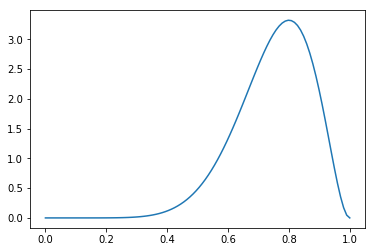

In [7]:
import scipy.stats as sts
nQ = 100
QVals = np.linspace(0,1,nQ)
Y_sum = np.sum(Y_coin)
PDF = sts.beta.pdf(QVals,1+Y_sum,1+len(Y_coin) - Y_sum)

plt.plot(QVals,PDF)

Questions[3].checkAnswer()


# Question 4




The previous problem dealt with the special case in which Bayes rule has a tractable 
analytic formula. In many cases, however, the integrals required in Bayes rule are intractable.

As we saw in class, the minimum mean-squared error estimator of of $x$ given data $y$ is given by the conditional mean:
\begin{equation*}
\hat x(y) = \E[x|y] = \int x p(x|y)dx. 
\end{equation*}

Recall the localization problem from range-finder data from the previous homework. We will work with a more refined model:
\begin{equation*}
y_i = \|x-c_i\| + 0.2 (1+\|x-c_i\|) v_i
\end{equation*}
where $v_i$ are indendent Gaussians with mean $0$ and variance $1$ for $i=0,\ldots,6$. Note here this has
the sensible property that measuement accuracy degrades as the distance increases.
Let $y$ be the vector of all sensor measurements.


To get a probabilistic estimator for $x$, assume that its prior distribution is a 2-dimensional Gaussian with mean zero and covariance $10 I$.


In this case, $p(x|y)$ cannot be explitly evaluated, and it cannot be sampled directly. 

Assume that the data, $y$, is fixed. Then note that $p(y|x)p(x) \propto p(x|y)$, where the normalization constant $p(y)$ is unknown. Assume that $q(x)$ is a probability density which is positive everywhere which we know how to evaluate and sample. 
Then the importance sampling estimate of $\E[x|y]$ is given by:

\begin{align*}
x_i &\sim q(x) \textrm{ for } i=1,\ldots,N\\
w_i &= \frac{p(y|x_i)p(x_i)}{q(x_i)} \textrm{ for } i=1,\ldots,N \\
\E[x|y] &\approx \frac{\sum_{i=1}^N x_i w_i}{\sum_{i=1}^N w_i}
\end{align*}

It can be shown by the of large that the approximation converges to the correct value as $N\to\infty$. 
Note that when calculating the weights, $w_i$, we really only need to evaluate $q(x_i)$ and $p(y|x_i)p(x_i)$ up to constant factors:
$\tilde q(x) \propto q(x)$ and $\tilde p(x) \propto p(y|x)p(x)$. (The normalization constants cancel in the division step.)

Assume the sensor locations and measurements are given by:


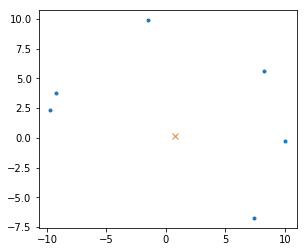

In [8]:
SensorLocs = np.array([[9.997, -0.226],
[-9.249, 3.803],
[-1.475, 9.891],
[8.242, 5.663],
[7.395, -6.732],
[-9.723, 2.337]])
YRange = np.array([5.532, 9.863, 8.628, 11.847, 9.747, 8.646])

# For reference the true value is Here
x_true = np.array([0.751595, 0.114994])
plt.plot(SensorLocs[:,0],SensorLocs[:,1],'.')
plt.plot(x_true[0],x_true[1],'x')
plt.gca().set_aspect('equal')


Use importance sampling to estimate $\E[x|y]$. Your result should be a length 2 vector called `x_IS`.



In [9]:
import numpy.random as rnd
import numpy.linalg as la
noiseStd = 0.2
priorVar = 10
nSensors = len(SensorLocs)

# This is called a lambda expression or inline function
# It is useful for making short simple functions
distFunc = lambda x : la.norm(SensorLocs-np.outer(np.ones(nSensors),x),axis=1)


def sensorLikelihood(x):
    d = distFunc(x)
    v = (noiseStd * (1+1* d))**2
    m = d
    expVal = -.5 * np.sum((YRange-m)**2 / v)
    return np.exp(expVal) / np.prod(np.sqrt(v))



NumSamp = 2000

X_samp = np.sqrt(priorVar) * rnd.randn(NumSamp,2)

# This is called a list comprehension
W = np.array([sensorLikelihood(x) for x in X_samp])

XW = X_samp * np.outer(W,np.ones(2))

x_IS = np.mean(XW,axis=0) / np.mean(W)

Questions[4].checkAnswer(x_IS)

Hoorah!
A score of 1 was entered for Question 4



As with many of the tests, this relies on statistics, correct answers have a small chance of being marked incorrect. 
However, depending on your choice of $q(x)$, the likelihood of error will be very small for sample counts of a few thousand.

# Final Score

You can run this code to see all of your scores.




In [10]:
Assignment.showResults()

Problem 0: 1
Problem 1: 1
Problem 2: 1
Problem 3: 1
Problem 4: 1

Total: 5 / 5





# Submission

Save your work and run this cell to submit. It will only work if you have the internet.

